<a href="https://colab.research.google.com/github/Vizzuality/copernicus-climate-data/blob/master/test_zarr_remote.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Prepare data for the copernicus climate project

https://github.com/Vizzuality/copernicus-climate-data

Edward P. Morris (vizzuality.)

MIT License

Copyright (c) 2020 Vizzuality

Permission is hereby granted, free of charge, to any person obtaining a copy
of this software and associated documentation files (the "Software"), to deal
in the Software without restriction, including without limitation the rights
to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
copies of the Software, and to permit persons to whom the Software is
furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all
copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
SOFTWARE.

# Setup

## Linux dependencies

In [1]:
!apt install libspatialindex-dev

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  libspatialindex-c4v5 libspatialindex4v5
The following NEW packages will be installed:
  libspatialindex-c4v5 libspatialindex-dev libspatialindex4v5
0 upgraded, 3 newly installed, 0 to remove and 25 not upgraded.
Need to get 555 kB of archives.
After this operation, 3,308 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libspatialindex4v5 amd64 1.8.5-5 [219 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libspatialindex-c4v5 amd64 1.8.5-5 [51.7 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libspatialindex-dev amd64 1.8.5-5 [285 kB]
Fetched 555 kB in 1s (418 kB/s)
Selecting previously unselected package libspatialindex4v5:amd64.
(Reading database ... 134448 files and directories currently installed.)
Preparing to unpack .../libspatialindex4v5_1.8.5-5_

## Python packages

In [2]:
!pip install cftime netcdf4 zarr xarray xclim gcsfs nc-time-axis

     |████████████████████████████████| 317kB 4.5MB/s 
     |████████████████████████████████| 4.1MB 27.9MB/s 
     |████████████████████████████████| 3.3MB 42.1MB/s 
     |████████████████████████████████| 92kB 11.2MB/s 
     |████████████████████████████████| 3.8MB 37.7MB/s 
     |████████████████████████████████| 71kB 9.3MB/s 
     |████████████████████████████████| 194kB 61.0MB/s 
     |████████████████████████████████| 14.7MB 52.4MB/s 
     |████████████████████████████████| 174kB 63.3MB/s 
     |████████████████████████████████| 10.4MB 42.0MB/s 
     |████████████████████████████████| 931kB 16.9MB/s 
     |████████████████████████████████| 604kB 62.3MB/s 
     |████████████████████████████████| 501kB 42.3MB/s 
     |████████████████████████████████| 276kB 50.8MB/s 
  Created wheel for zarr: filename=zarr-2.4.0-cp36-none-any.whl size=127066 sha256=7522afd22781ab9d3a3c81c152a23ae0e02de966022798effc66caa54796a17b
  Stored in directory: /root/.cache/pip/wheels/e1/5b/25/24c685604b9113

## Authorisation

In [0]:
# For auth WITHOUT service account
#from google.colab import auth
#auth.authenticate_user()

# https://cloud.google.com/resource-manager/docs/creating-managing-projects
#project_id = "skydipper-196010"
#!gcloud config set project {project_id}

In [0]:
# Copy GC credentials to home (place in your GDrive, and connect Drive)
!cp "/content/drive/My Drive/skydipper-196010-f842645fd0f3.json" "/root/.skydipper-196010-f842645fd0f3.json"

In [5]:
# Auth WITH service account
!gcloud auth activate-service-account \
  edward-morris@skydipper-196010.iam.gserviceaccount.com \
          --key-file=/root/.skydipper-196010-f842645fd0f3.json --project="skydipper-196010"


Activated service account credentials for: [edward-morris@skydipper-196010.iam.gserviceaccount.com]


In [6]:
# Test GC auth
!gsutil ls "gs://copernicus-climate"

gs://copernicus-climate/RH_ERA5.zip
gs://copernicus-climate/variables_futuro_CMIP5_AEMET.zip
gs://copernicus-climate/variables_futuro_CMIP5_ERA5land_1.zip
gs://copernicus-climate/variables_futuro_CMIP5_ERA5land_2.zip
gs://copernicus-climate/variables_futuro_CMIP5_ERA5land_3.zip
gs://copernicus-climate/variables_futuro_CMIP5_ERA5land_4.zip
gs://copernicus-climate/variables_futuro_seasonal_ERA5land_1.zip
gs://copernicus-climate/variables_futuro_seasonal_ERA5land_2.zip
gs://copernicus-climate/variables_futuro_seasonal_ERA5land_3.zip
gs://copernicus-climate/ws_ERA5.zip
gs://copernicus-climate/dataset/
gs://copernicus-climate/spain.zarr/


In [0]:
# Clean up
!rm -r sample_data

# Utils

In [9]:
import xarray as xr
# Set display to HTML sytle (optional)
xr.set_options(display_style='html', display_width=50)

In [0]:
import gcsfs
import zarr
import xarray as xr
import xclim as xc

def get_cached_zarr(
    group,
    project_id = "skydipper-196010",
    root = "copernicus-climate/spain.zarr",
    token="/root/.skydipper-196010-f842645fd0f3.json"
    ):
  
  # Connect to GS
  gc = gcsfs.GCSFileSystem(project=project_id, token=token)
  path_or_store = gcsfs.mapping.GCSMap(root, gcs=gc, check=True, create=False)
  # Check zarr is consolidated
  consolidated = gc.exists(f'{root}/.zmetadata')
  # Cache the zarr store
  cache = zarr.LRUStoreCache(path_or_store, max_size=2**28)
  # Return cached zarr group
  return xr.open_zarr(cache, group=group, consolidated=consolidated)

In [20]:
%%time
sosl = get_cached_zarr("seasonal-original-single-levels")

CPU times: user 78 ms, sys: 2.95 ms, total: 81 ms
Wall time: 1.84 s


In [21]:
%%time
pcdsl = get_cached_zarr("projections-cmip5-daily-single-levels")

CPU times: user 180 ms, sys: 6.24 ms, total: 187 ms
Wall time: 1.92 s


In [22]:
sosl

,Array,Chunk
Bytes,71.05 MB,11.84 MB
Shape,"(6, 1, 51, 215, 9, 15)","(1, 1, 51, 215, 9, 15)"
Count,7 Tasks,6 Chunks
Type,float64,numpy.ndarray
,Array,Chunk
Bytes,71.05 MB,11.84 MB
Shape,"(6, 1, 51, 215, 9, 15)","(1, 1, 51, 215, 9, 15)"
Count,7 Tasks,6 Chunks
Type,float64,numpy.ndarray


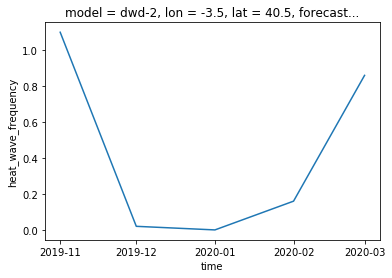

In [33]:
import xclim as xc

def calc_monthly_heat_wave_frequency(ds, thresh_tasmax='15 C', thresh_tasmin='5 C', window=2):
  return xc.atmos.heat_wave_frequency(tasmax=ds.tasmax, tasmin=ds.tasmin, thresh_tasmax=thresh_tasmax, thresh_tasmin=thresh_tasmin, window=window, freq='MS')

pt = [40.411335, -3.674908]
hwf = calc_monthly_heat_wave_frequency(sosl.sel(model='dwd-2')).squeeze().mean('realization').chunk({"time":-1})
hwf.sel(lat=pt[0], lon=pt[1], method='nearest').plot()  

In [34]:
pcdsl

<xarray.Dataset>
Dimensions:      (experiment: 2, lat: 8, lon: 8, model: 5, realization: 1, time: 34310)
Coordinates:
  * experiment   (experiment) object 'rcp85' 'rcp45'
    height       (model) float64 dask.array<chunksize=(5,), meta=np.ndarray>
  * lat          (lat) float64 35.0 ... 43.75
  * lon          (lon) float64 -9.375 ... 3.75
  * model        (model) object 'BNU-ESM' ... 'MPI-ESM-LR'
  * realization  (realization) int64 1
  * time         (time) object 2006-01-01 00:00:00 ... 2099-12-31 00:00:00
Data variables:
    tasmax       (model, experiment, time, lat, lon, realization) float64 dask.array<chunksize=(1, 1, 34310, 8, 8, 1), meta=np.ndarray>
    tasmin       (model, experiment, time, lat, lon, realization) float64 dask.array<chunksize=(1, 1, 34310, 8, 8, 1), meta=np.ndarray>
Attributes:
    Conventions:    CF-1.4
    comment:        minimum near-surface (usual...
    contact:        Ji Duoying (duoyingji@bnu.e...
    creation_date:  2012-04-11T10:34:34Z
    history:        2012-04-11T10:34:29Z CMOR r...
    institution:    GCESS,BNU,Beijing,China
    source:         BNU-ESM, CDS
    title:          BNU-ESM model output prepar...

CPU times: user 28.8 s, sys: 2.59 s, total: 31.3 s
Wall time: 29 s


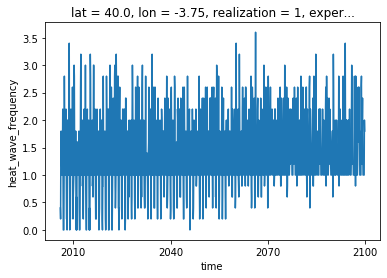

In [38]:
%%time
import xclim as xc

def calc_monthly_heat_wave_frequency(ds, thresh_tasmax='15 C', thresh_tasmin='5 C', window=2):
  return xc.atmos.heat_wave_index(tasmax=ds.tasmax, tasmin=ds.tasmin, thresh_tasmax=thresh_tasmax, thresh_tasmin=thresh_tasmin, window=window, freq='MS')

pt = [40.411335, -3.674908]
hwf = calc_monthly_heat_wave_frequency(pcdsl.sel(experiment='rcp85').squeeze().sel(lat=pt[0], lon=pt[1], method='nearest')).mean('model')
hwf.plot()  

In [0]:
from gcsfs import GCSFileSystem
import zarr
import xarray as xr
import xclim as xc

def get_monthly_heatwaves(
    pt = [40.411335, -3.674908],
    thresh_tasmax='25 C', thresh_tasmin='20 C', window=2,
    project_id = "skydipper-196010",
    root = "copernicus-climate/spain.zarr",
    group="daily_reanalysis-era5-land_min-max_temperature",
    token="/root/.skydipper-196010-f842645fd0f3.json"
    ):
  
  # Connect to GS
  gc = GCSFileSystem(project_id, token=token)
  consolidated = gc.exists(f'{root}/.zmetadata')
  path_or_store = gc.mapping(root, check=False)
  # Cache the zarr store
  cache = zarr.LRUStoreCache(path_or_store, max_size=2**28)
  # Read zarr
  ds = xr.open_zarr(cache, group=group, consolidated=consolidated) \
  .sel(latitude=pt[0], longitude=pt[1], method='nearest').chunk({"time":-1})
  return xc.indices.heat_wave_frequency(tasmax=ds.tasmax, tasmin=ds.tasmin, thresh_tasmax=thresh_tasmax, thresh_tasmin=thresh_tasmin, window=window, freq='MS')


<xarray.DataArray (time: 455)>
dask.array<where, shape=(455,), dtype=float64, chunksize=(14,), chunktype=numpy.ndarray>
Coordinates:
  * time       (time) datetime64[ns] 1981-01-01 ... 2018-11-01
    longitude  float32 -3.7
    latitude   float32 40.4
Attributes:
    units:    
CPU times: user 2.08 s, sys: 174 ms, total: 2.26 s
Wall time: 2.13 s


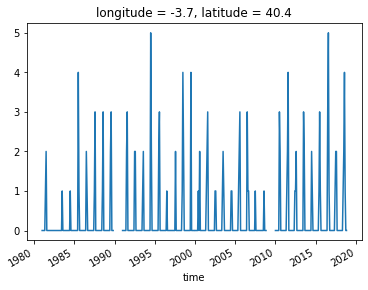

In [0]:
%%time
out = get_monthly_heatwaves(thresh_tasmax='27 C', thresh_tasmin='20 C', window=2)
print(out)
out.plot()

In [0]:
import itertools
from typing import Dict, Tuple, Iterable

import numpy as np
import xarray as xr

def update_dataset_chunk_encoding(dataset: xr.Dataset,
                                  chunk_sizes: Dict[str, int] = None,
                                  format_name: str = None,
                                  in_place: bool = False) -> xr.Dataset:
    """
    Update each variable's encoding in *dataset* with respect to *chunk_sizes*
    so *dataset* is written in chunks for given *format_name*.
    :param dataset: input dataset.
    :param chunk_sizes: the chunk sizes to be used for the encoding.
        If None, any chunking encoding is removed.
    :param format_name: format name, e.g. "zarr" or "netcdf4".
    :param in_place: If ``True``, *dataset* will be modified in place and returned.
    """
    if format_name == FORMAT_NAME_ZARR:
        chunk_sizes_attr_name = "chunks"
    elif format_name == FORMAT_NAME_NETCDF4:
        chunk_sizes_attr_name = "chunksizes"
    else:
        return dataset
    if not in_place:
        dataset = dataset.copy()
    for var_name in dataset.variables:
        var = dataset[var_name]
        if chunk_sizes is not None:
            def get_size(i):
                dim_name = var.dims[i]
                size = chunk_sizes.get(dim_name)
                if isinstance(size, int):
                    return size
                if var.chunks:
                    size = var.chunks[i]
                    if isinstance(size, int):
                        return size
                    if len(size):
                        return size[0]
                return var.shape[i]

            var.encoding.update({chunk_sizes_attr_name: tuple(map(get_size, range(var.ndim)))})
        elif chunk_sizes_attr_name in var.encoding:
            # Remove any explicit and possibly unintended specification
            del var.encoding[chunk_sizes_attr_name]
    return dataset


def chunk_dataset(dataset: xr.Dataset,
                  chunk_sizes: Dict[str, int] = None,
                  format_name: str = None) -> xr.Dataset:
    """
    Chunk *dataset* using *chunk_sizes* and optionally update encodings for given *format_name*.
    :param dataset: input dataset
    :param chunk_sizes: mapping from dimension name to new chunk size
    :param format_name: optional format, e.g. "zarr" or "netcdf4"
    :return: the (re)chunked dataset
    """
    dataset = dataset.chunk(chunks=chunk_sizes)
    if format_name:
        dataset = update_dataset_chunk_encoding(dataset, chunk_sizes=chunk_sizes, format_name=format_name)
    return dataset


def get_empty_dataset_chunks(dataset: xr.Dataset) -> Dict[str, Tuple[Tuple[int, ...]]]:
    """
    Identify empty dataset chunks and return their indices.
    :param dataset: The dataset.
    :return: A mapping from variable name to a list of block indices.
    """
    return {var_name: get_empty_var_chunks(dataset[var_name]) for var_name in dataset.data_vars}


def get_empty_var_chunks(var: xr.DataArray) -> Tuple[Tuple[int, ...]]:
    """
    Identify empty variable chunks and return their indices.
    :param var: The variable.
    :return: A list of block indices.
    """
    chunks = var.chunks
    if chunks is None:
        raise ValueError('data array not chunked')

    chunk_slices = compute_chunk_slices(chunks)

    empty_chunk_indexes = []
    for chunk_index, chunk_slice in chunk_slices:
        data_index = tuple(slice(start, end) for start, end in chunk_slice)
        data = var[data_index]
        if np.all(np.isnan(data)):
            empty_chunk_indexes.append(chunk_index)
            # print(f'empty: {var.name}/{".".join(map(str, chunk_index))}')

    # noinspection PyTypeChecker
    return tuple(empty_chunk_indexes)


def compute_chunk_slices(chunks: Tuple[Tuple[int, ...], ...]) -> Iterable:
    chunk_indices = []
    for c in chunks:
        chunk_indices.append(tuple(i for i in range(len(c))))

    chunk_slices = []
    for c in chunks:
        x = []
        o = 0
        for s in c:
            x.append((o, o + s))
            o += s
        chunk_slices.append(tuple(x))
    return zip(itertools.product(*chunk_indices), itertools.product(*chunk_slices))

In [0]:
get_empty_dataset_chunks(ds)

KeyboardInterrupt: ignored